# Topic Classification and Trend Visualization

## Data Preparation
- Extracted **Title** and **Abstract** from the `authors.leptospirosis.csv` file to analyze topics.

## Topic Classification
1. Initially attempted to classify into **10 topics**, but some articles were not assigned (values were 0).  
2. Reduced the number of topics and successfully classified into **6 topics**.  
3. Interpreted the content of each topic to identify key characteristics and themes.

## Yearly Trend Analysis
1. Counted the yearly occurrences for each topic.  
2. Visualized the yearly proportions of topics using a **Stacked Area Chart** to show trends over time.

## Purpose of Visualization
- To observe the rise and fall of research topics at a glance.  
- To highlight the importance of specific topics during certain periods and clarify how research priorities shifted over time.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity

import plotly.express as px
import plotly.graph_objects as go

In [77]:
# Reading the CSV files
articles_df = pd.read_csv('../data/articles.leptospirosis.csv')
authors_df = pd.read_csv('../data/authors.leptospirosis.csv')
paper_counts_df = pd.read_csv('../data/paper_counts.csv')

# display(articles_df.head())
# display(authors_df.head())
# display(paper_counts_df.head())

# # Check the data types and basic structure of the dataframes
# print(articles_df.info())
# print(authors_df.info())
# print(paper_counts_df.info())

# # Check for missing values in each dataset
# print(articles_df.isnull().sum())
# print(authors_df.isnull().sum())
# print(paper_counts_df.isnull().sum())

In [26]:
# Drop rows with missing values in specific columns
# Remove rows with missing values in the articles DataFrame
# articles_df_cleaned = articles_df.dropna()
# authors_df_cleaned = authors_df.dropna()
# paper_counts_df_cleaned = paper_counts_df.dropna()

# Drop duplicate rows
# articles_df.drop_duplicates(inplace=True)
# authors_df.drop_duplicates(inplace=True)
# paper_counts_df.drop_duplicates(inplace=True)

# # Check if there are any missing values left
# print(articles_df.isnull().sum())
# print(authors_df.isnull().sum())

In [78]:
# Check the data types of each column
# print(articles_df.dtypes)

# Example of type conversion if needed
# articles_df.loc[:, 'Year'] = articles_df['Year'].astype(int)

In [149]:
num_topics = 6

# Combine the title and abstract into a single text column
articles_df['Text'] = articles_df['Title'].fillna('') + ' ' + articles_df['Abstract'].fillna('')

# Set up the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = tfidf_vectorizer.fit_transform(articles_df['Text'])

lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X)

# Get the topic distribution for each document
topic_distribution = lda.transform(X)

# Assign each document to its most likely topic
topic_assignments = topic_distribution.argmax(axis=1)

In [115]:
# Function to calculate the overlap between topics
def get_topic_overlap(lda, tfidf_vectorizer, num_topics):
    words = np.array(tfidf_vectorizer.get_feature_names_out())
    topic_vectors = []

    # Construct topic vectors using the highest-weighted words
    for topic in lda.components_:
        topic_vector = np.zeros(len(words))
        for idx in topic.argsort()[-10:]:  # Top 10 words for each topic
            topic_vector[idx] = topic[idx]
        topic_vectors.append(topic_vector)

    similarity_matrix = cosine_similarity(topic_vectors)
    return similarity_matrix, words

# Calculate the topic similarity and get the words
similarity_matrix, words = get_topic_overlap(lda, tfidf_vectorizer, num_topics)

# Create a dataframe to hold the x and y coordinates for the circles
topic_positions = np.random.rand(num_topics, 2)  # Random initial positions for topics

# Create the plotly figure
fig = go.Figure()

# Add circles for each topic with distinct colors
for i in range(num_topics):
    # Use a random position for each circle
    x_pos, y_pos = topic_positions[i]

    # Add the circle for the current topic with a specific color
    fig.add_trace(go.Scatter(
        x=[x_pos], y=[y_pos], mode="markers", marker=dict(
            size=90, opacity=0.6, line=dict(width=2, color="black"),
            symbol="circle", color=color_sequence[i], sizemode="diameter"),
        name=f"Topic {i + 1}"
    ))

    # Get the top 30 words for the current topic
    top_words = [words[idx] for idx in lda.components_[i].argsort()[-30:]]

    # Add the topic name with top words to the legend (display only the name)
    fig.add_trace(go.Scatter(
        x=[None], y=[None], mode="text", text=[f"Topic {i + 1}: " + ', '.join(top_words)],
        showlegend=True, name=f"Topic {i + 1}"
    ))

# Overlay the circles based on similarity
for i in range(num_topics):
    for j in range(i + 1, num_topics):
        similarity_score = similarity_matrix[i, j]

        if similarity_score > 0.5:  # Only draw lines for significant overlaps

            # Calculate the overlap based on the similarity score
            x_overlap = [topic_positions[i][0], topic_positions[j][0]]
            y_overlap = [topic_positions[i][1], topic_positions[j][1]]

            # Draw a line (representing overlap) between the topics
            fig.add_trace(go.Scatter(
                x=x_overlap, y=y_overlap, mode='lines', line=dict(width=2, color="black"),
                opacity=similarity_score, showlegend=False
            ))

# Set layout to make it more readable and reduce the size of the plot
fig.update_layout(
    title="Topic Overlap Visualization with Color Coding and Top 30 Words in Legend",
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False),
    showlegend=True,
    plot_bgcolor="white",
    width=600,
    height=600
)

fig.show()


In [ ]:
# Ccolors for the line plot (aligned with year-wise stacked chart)
color_sequence = [
    '#b4a7d6',  # Light Purple
    '#c27ba0',  # Greige (Grayish Beige)
    '#9fc5e8',  # Light Blue
    '#b6d7a8',  # Light Green
    '#ffd966',  # Dark Yellow
    '#f4cccc',  # Light Pink
    '#ce7e00',  # Dark Brown
    '#d9d9d6',  # Light Gray
    '#444444',  # Dark Gray
    '#a52a2a',  # Brown
]

# Step 1: Ensure 'PMID' column is string type in both DataFrames
authors_df['PMID'] = authors_df['PMID'].astype(str)
articles_df['PMID'] = articles_df['PMID'].astype(str)

# Step 2: Create a full name for each author
authors_df['FullName'] = authors_df['AuthorInitials'].fillna('') + ' ' + authors_df['AuthorLastname'].fillna('')
authors_df['FullName'] = authors_df['FullName'].str.strip()  # Remove extra spaces

# Step 3: Extracting the top words for each topic
feature_names = tfidf_vectorizer.get_feature_names_out()
topic_words = []
for topic_idx, topic in enumerate(lda.components_):
    top_words_idx = topic.argsort()[:-11:-1]  # Get top 10 words for each topic
    top_words = [feature_names[i] for i in top_words_idx]
    topic_words.append(top_words)

# Topic summaries (short descriptions based on top words)
topic_summaries = {}
for i, words in enumerate(topic_words):
    summary = f"Topic {i+1}: " + ", ".join(words)  # Create summary from top 10 words
    topic_summaries[i] = summary
    print(summary)

# Step 4: Group the topic distribution by year and calculate the total number of articles per topic per year
articles_df['Year'] = articles_df['Year'].astype(int)

topic_by_year = pd.DataFrame(topic_distribution, columns=[f'Topic {i+1}' for i in range(lda.n_components)])
topic_by_year['Year'] = articles_df['Year']
topic_by_year_count = topic_by_year.groupby('Year').sum()  # Total number of articles for each topic per year

# Calculate total articles per year
total_articles_per_year = topic_by_year_count.sum(axis=1)

# Create the bar plot with actual article counts (not proportions)
fig = px.bar(
    topic_by_year_count,
    x=topic_by_year_count.index,
    y=topic_by_year_count.columns,
    labels={"x": "Year", "value": "Number of Articles", "variable": "Topics"},
    title="Number of Articles by Topic Over Time",
    template="plotly_white",
    color_discrete_sequence=color_sequence  # Apply the custom muted color sequence directly
)

# Update the hover info to show the topic summary on hover
for i, col in enumerate(topic_by_year_count.columns):
    fig.data[i].name = topic_summaries[i]  # Assign topic summaries as hover labels

# Customize layout
fig.update_layout(
    xaxis_title="Year",
    yaxis_title="Number of Articles",
    barmode='stack',
    hovermode='x unified',
    width=1200,
    height=600,
    legend=dict(
        yanchor='bottom',
        xanchor='center'
    )
)

fig.show()

# Step 5: Display the topic distribution by year
print("Topic distribution by year:")
print(topic_by_year_count)


Topic 1: assay, test, pcr, diagnosis, elisa, leptospirosis, vaccine, detection, mat, igm
Topic 2: sri, lanka, hantavirus, deer, zealand, cows, farm, bovine, dairy, herds
Topic 3: leptospirosis, patients, severe, acute, clinical, case, pulmonary, renal, failure, fever
Topic 4: leptospira, interrogans, proteins, protein, pathogenic, leptospiral, host, expression, cells, immune
Topic 5: leptospirosis, leptospira, risk, disease, study, cases, animals, dogs, human, factors
Topic 6: typhus, diseases, scrub, leptospirosis, health, infections, fever, malaria, india, review


Topic distribution by year:
        Topic 1   Topic 2    Topic 3    Topic 4     Topic 5    Topic 6
Year                                                                  
1944   0.027814  0.027520   0.028085   0.199281    0.689672   0.027628
1945   0.157720  0.030951   0.032183   0.716800    0.031251   0.031095
1960   0.054114  0.053396   0.565566   0.053765    1.219310   0.053848
1961   0.107050  0.106390   0.108041   0.341308    3.177790   0.159422
1963   0.028295  0.028103   0.436832   0.450205    0.028350   0.028216
1964   0.894154  0.054331   0.055507   0.054798    0.886785   0.054426
1970   0.133448  0.132029   0.136205   1.737118    1.728610   0.132590
1976   0.066353  0.065972   0.066483   0.067077    1.667944   0.066172
1977   0.032056  0.032736   0.031943   0.031842    0.839583   0.031841
1981   0.029501  0.029394   0.029713   0.029475    0.852364   0.029554
1982   0.345783  0.100323   0.099933   0.099541    3.254903   0.099517
1984   0.041807  0.040954   0.041419   0.041985  

C:\Users\small\AppData\Local\Temp\ipykernel_10080\1233385569.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



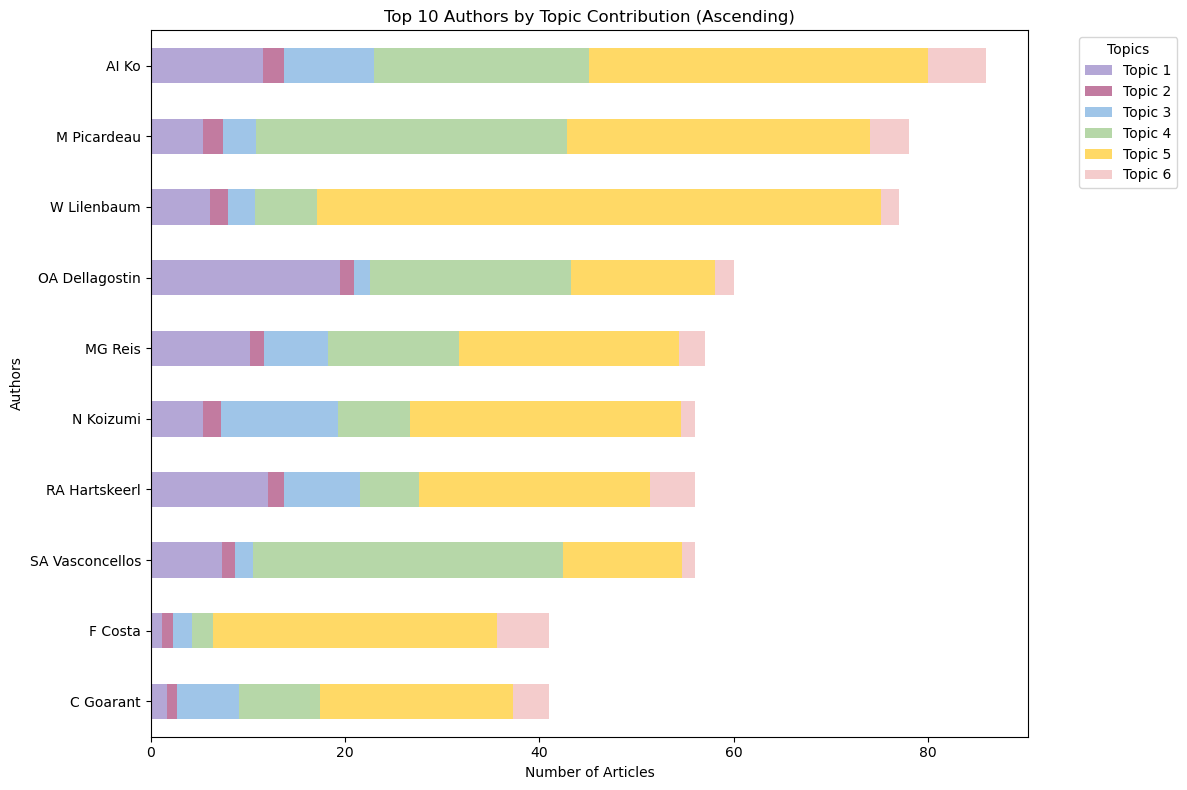

Top 10 Authors by Total Articles (Ascending):
                   Topic 1   Topic 2    Topic 3    Topic 4    Topic 5  \
C Goarant         1.672179  1.053036   6.346239   8.379380  19.805242   
F Costa           1.161137  1.136412   1.948752   2.147715  29.244599   
SA Vasconcellos   7.352067  1.312263   1.909423  31.847645  12.242839   
RA Hartskeerl    12.094438  1.606955   7.845404   6.017391  23.866669   
N Koizumi         5.351581  1.873610  12.050258   7.374459  27.959815   
MG Reis          10.193479  1.424857   6.629575  13.437372  22.676851   
OA Dellagostin   19.441051  1.450244   1.697643  20.678899  14.774116   
W Lilenbaum       6.105009  1.852947   2.736162   6.458178  57.990028   
M Picardeau       5.411887  1.992096   3.442646  32.045837  31.079336   
AI Ko            11.545072  2.225290   9.173173  22.170683  34.837161   

                  Topic 6  Total  
C Goarant        3.743923   41.0  
F Costa          5.361385   41.0  
SA Vasconcellos  1.335762   56.0  
RA Hartske

In [153]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Ensure 'PMID' column is string type in both DataFrames
authors_df['PMID'] = authors_df['PMID'].astype(str)
articles_df['PMID'] = articles_df['PMID'].astype(str)

# Step 2: Create a full name for each author
authors_df['FullName'] = authors_df['AuthorInitials'].fillna('') + ' ' + authors_df['AuthorLastname'].fillna('')
authors_df['FullName'] = authors_df['FullName'].str.strip()  # Remove extra spaces

# Step 3: Get total articles count per author
article_counts_per_author = articles_df.groupby('PMID')['Year'].count().reset_index()
article_counts_per_author.columns = ['PMID', 'ArticleCount']

# Merge this back to authors_df to get the total article count per author
author_article_counts = authors_df.merge(article_counts_per_author, on='PMID')

# Step 4: Find top 10 authors by article count
top_10_authors = author_article_counts.groupby('FullName')['ArticleCount'].sum().sort_values(ascending=False).head(10)

# Step 5: Get articles for each of the top 10 authors
top_10_articles = articles_df[articles_df['PMID'].isin(author_article_counts[author_article_counts['FullName'].isin(top_10_authors.index)]['PMID'])]

# Step 6: Get the topic distribution for each article
# Here, ensure topic distribution is correctly indexed
top_10_articles['TopicDistribution'] = [topic_distribution[articles_df[articles_df['PMID'] == pmid].index[0]] for pmid in top_10_articles['PMID']]

# Step 7: Initialize a dictionary for counting topics per author
author_topic_counts = {author: {f'Topic {i+1}': 0 for i in range(lda.n_components)} for author in top_10_authors.index}

# Step 8: Loop through each article and count the topics for each author
for index, article in top_10_articles.iterrows():
    pmid = article['PMID']
    authors = authors_df[authors_df['PMID'] == pmid]['FullName'].values
    topic_dist = article['TopicDistribution']
    
    # Increment the topic count for each author based on the topic distribution
    for author in authors:
        if author in author_topic_counts:
            for topic_idx in range(lda.n_components):
                # Add topic contribution to the author
                author_topic_counts[author][f'Topic {topic_idx+1}'] += topic_dist[topic_idx]

# Step 9: Convert the dictionary to a DataFrame for later use
author_topic_df = pd.DataFrame.from_dict(author_topic_counts, orient='index')

# Step 10: Sort the DataFrame in ascending order by total article count (across all topics)
author_topic_df['Total'] = author_topic_df.sum(axis=1)
author_topic_df = author_topic_df.sort_values(by='Total', ascending=True)  # Sort in ascending order

# Step 11: Plot the data (stacked bar chart)
author_topic_df.drop(columns='Total').plot(kind='barh', stacked=True, figsize=(12, 8), color=color_sequence[:lda.n_components]) 
plt.title('Top 10 Authors by Topic Contribution (Ascending)')
plt.xlabel('Number of Articles')
plt.ylabel('Authors')
plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Step 12: Display the top 10 authors by total article count
print("Top 10 Authors by Total Articles (Ascending):")
print(author_topic_df)
